In [1]:
# %matplotlib inline
# import mpld3
# mpld3.enable_notebook()

'''
Import Libraries
'''

import sys
import os
import numpy as np
sys.path.append(os.chdir(os.path.dirname(os.path.abspath(".")) + "/bin"))

# matplotlib.use('nbagg')
import matplotlib.pyplot as plt

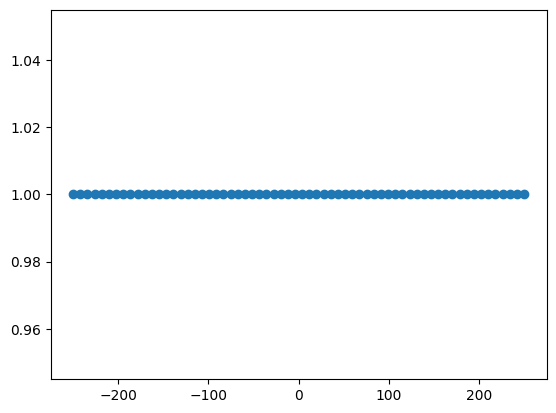

In [2]:
'''
Create array containing positions of antennas

Antennas can be distributed linearly, randomly, or a mix of both
'''
N = 64
max_pos = 250
Antenna_positions = 'Linear'

if Antenna_positions == 'Linear':
    pos = np.linspace(-max_pos,max_pos,N)
elif Antenna_positions == 'Random':
    pos = 2*max_pos*np.random.uniform(size=N)
elif Antenna_positions == 'Linear with Random':
    pos = np.linspace(-max_pos,max_pos,N)
    pos[0] = np.random.uniform(-max_pos,max_pos)
    pos[1] = np.random.uniform(-max_pos,max_pos)
    pos[2] = np.random.uniform(-max_pos,max_pos)
    
plt.scatter(pos, np.ones(64))
plt.show()

In [4]:
'''
Create Fourier coefficient matrix
'''

c = 299792458.0
zero_pt = 0              # Can be used if the first few channels have been flagged
gpu = 0                  # Determines the bandwidth in any gpu
tot_channels = 2048
n_gpus = 8               # Number of GPUs in system
bw_per_channel = (1.53 - 1.28)/tot_channels
N_BEAMS = 256
N_FREQ = tot_channels // n_gpus # get result as an integer


field_of_view_half_angle = 3.5
theta = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, N_BEAMS) #beam angles

freq = [1.53 - (zero_pt + gpu * tot_channels/(n_gpus-1) + i)* bw_per_channel for i in range(N_FREQ)]

form_beams_with_freq = range(256)
A = np.zeros((len(form_beams_with_freq), N_BEAMS, N), dtype=np.complex64) # Allocate space

'''
Calculate the fourier coefficients

Note we use np.round so that each number is ~ an 8-bit integer
'''
for k, f in enumerate(form_beams_with_freq):
    wavelength = c/(freq[f]*1e9)
    for i in range(N_BEAMS):
        for j in range(N):
            A[k, i,j] = np.round(127.0*np.exp(-2.0j*np.pi*pos[j]*np.sin(theta[i])/wavelength))/127.0

In [8]:
'''
Create the test signals
'''
eval_pts = 1024 #number of test signals
N_AVERAGING = 1
file_name = "python_data_navg_%d"% N_AVERAGING

try:
    out = np.load(file_name + ".npy")
    # print "Loading from Memory: " + file_name
    print("Loading from Memory: " + file_name)
except:
    angles = np.linspace(-field_of_view_half_angle*np.pi/180.0, field_of_view_half_angle*np.pi/180.0, eval_pts)
    out = np.zeros((N_BEAMS, eval_pts))

    '''
    Note we use np.round so that each number is ~ an 4-bit integer

    This loop can take a while to calculate
    '''
    for k, f in enumerate(form_beams_with_freq):
        if (k%20 == 0): print(k)
        wavelength = c/(freq[f]*1e9)
        for jj in range(len(angles)):
            signal = [np.round(7*np.exp(2*np.pi*1j*pos[i]*np.sin(angles[jj])/wavelength)) for i in range(N)]
            out[:,jj] += 2*N_AVERAGING*np.real(np.dot(A[k,:,:], signal))**2
    np.save(file_name, out)
    # print "Saving to Memory: " + file_name
    print("Saving to Memory: " + file_name)

0
20
40
60
80
100
120
140
160
180
200
220
240
Saving to Memory: python_data_navg_1


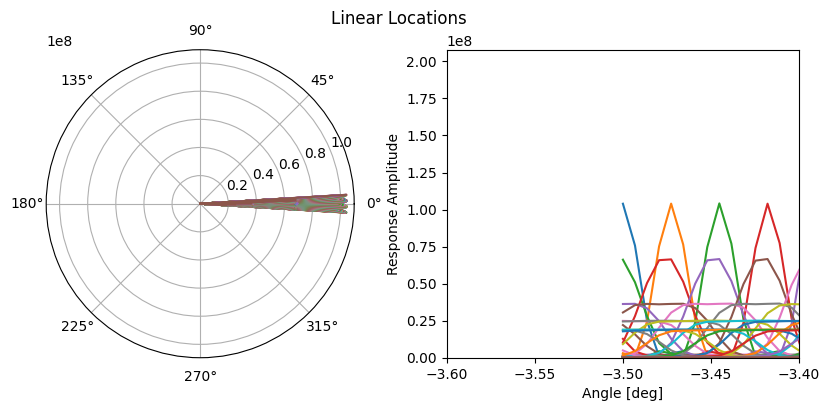

In [9]:
# mpld3.disable_notebook()
# %matplotlib tk

'''
Plot beams patterns over top of eachother

Change "eval_pts" if more resolution is desired
'''

fig = plt.figure(figsize=(10,4))
fig.suptitle(Antenna_positions + " Locations")
ax = plt.subplot(121,projection='polar')
ax2 = plt.subplot(122)

for jj in range(256):
    ax.plot(angles, np.real(out[jj]))
    ax2.plot(angles*180/np.pi, np.real(out[jj]))
    
ax2.axis([-3.6, -3.4, -100, 2.0*max(out[0])])
ax2.set_xlabel("Angle [deg]")
ax2.set_ylabel("Response Amplitude")

plt.show()
# mpld3.enable_notebook()

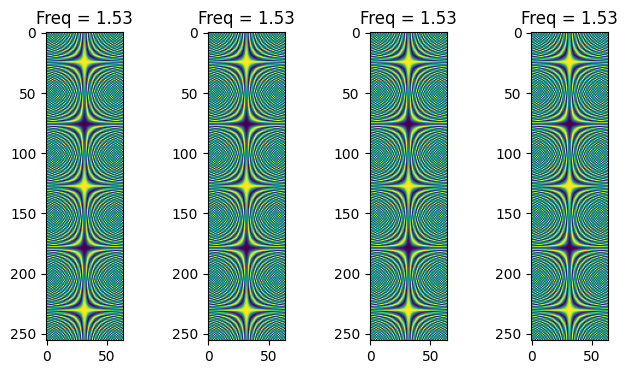

In [10]:
'''
Plot Fourier coefficient matricies for 4 frequencies
'''

fig = plt.figure(figsize= (8,4))
tr = 141
for k in range(4):
    ax = plt.subplot(tr)
    tr+=1
    ax.imshow(np.real(A[k]))
    ax.set_title("Freq = {0:.4g}".format(freq[form_beams_with_freq[k]]))
plt.show()

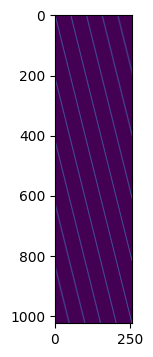

In [11]:
'''
Plot Intensity as a function of source direction and beam number (2d plot)
'''

fig = plt.figure(figsize= (10,4))
plt.imshow(out.T)
plt.show()


In [50]:
'''
GPU BEAMFORMER VALIDATION

This block compares the GPU implementation with the python implementation for a demonstration of correctness.
The GPU code exports a file called data.py which is stored in bin/. This code reads in that file and compares
it to the calculations made previously.

Note that to be accurate, N_AVERAGING, N_BEAMS, N_FREQS, etc. have to be the same for both implementations.
'''


# import os, sys
try:
    import data
except:
    reload(data)
da = np.array(data.A)

vmx = max(np.max(data.A), np.max(out)) #determines scale

#Plot GPU image
ax = plt.subplot(131)
ax.set_title("GPU")
ax.set_ylabel("Source Direction")
ax.set_xlabel("Beam Number")

#plot Python image
ax2 = plt.subplot(132)
ax2.set_title("Python")
ax2.set_xlabel("Beam Number")
# ax2.colorbar()

#plot percent difference image
ax3 = plt.subplot(133)
ax3.set_title("Difference")
b = np.abs((out.T - da)/out.T)
plt.suptitle("Beamformer Validation")
ax3.set_xlabel("Beam Number")

im = ax.imshow(da, vmin = 0, vmax = vmx)
im2 = ax2.imshow(out.T, vmin = 0, vmax = vmx)
im3 = ax3.imshow(b*100, vmin = 0, vmax = 1)

fig.colorbar(im2, ax = ax2)
fig.colorbar(im3, ax = ax3)

plt.show()
print(np.sqrt(np.sum(b**2)/(1024*256)))
print(np.mean(b)*100)

0.0008414656773568963
0.038731603963115105


In [32]:
'''
Plot histograms of both images and errors
'''

ax = plt.subplot(121)
ax2 = plt.subplot(122)
_, bi, _ = ax.hist(x = np.log10(out.ravel()), bins=20, alpha = .7, log = True, label =  "Python")
ax.hist(x = np.log10(da.ravel()), bins=bi, alpha = .7, log = True, label = "GPU")
ax.set_title("Python vs GPU Image Histograms")
ax.set_xlabel("$\log_{10}$(Pixel Intensity)")
ax.legend()

ax2.hist(x = (b*100).ravel(), bins=20, alpha = .7, log = True)
ax2.set_title("Errors")
ax2.set_xlabel("% error")

plt.suptitle("Comparison of Beamformer Results")
plt.show()